# RBM

In [1]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm

from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix


from reco_utils.dataset import movielens
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

System version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version: 0.25.1


In [2]:
data = pd.read_csv("MovieLensSmall.csv")

In [3]:
data.head()

,userId,Product_Id,Ratings,timestamp
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,115,265,2,881171488


In [4]:
#to use standard names across the analysis 
header = {
        "col_user": "userId",
        "col_item": "Product_Id",
        "col_rating": "Ratings",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(DF = data, **header)

#obtain the sparse matrix 
X = am.gen_affinity_matrix()

In [5]:
Xtr, Xtst = numpy_stratified_split(X)

In [6]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (943, 464)
test matrix size (943, 464)


In [7]:
#First we initialize the model class
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



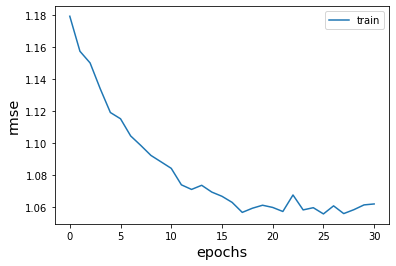

In [8]:
#Model Fit
train_time= model.fit(Xtr, Xtst)

In [9]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k, test_time =  model.recommend_k_items(Xtst)

In [10]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [11]:
top_k_df.head(10)

,userId,Product_Id,prediction
0,1,113,4.580922
1,1,81,4.421617
2,1,267,4.574813
3,1,40,4.568272
4,1,100,4.364933
5,1,269,4.551864
6,1,166,4.796572
7,1,190,4.668014
8,1,242,4.362865
9,1,152,4.393866


In [12]:
#top_k_df.to_csv("RBM.csv")
abc = top_k_df[top_k_df["userId"]==260]
abc.head()

,userId,Product_Id,prediction
2590,260,78,3.370067
2591,260,247,3.173074
2592,260,119,3.879524
2593,260,114,3.864145
2594,260,313,4.994019


In [13]:
prodIDNames = pd.read_csv("ProductIdwithNames.csv")

In [14]:
merged_inner = pd.merge(left=abc, right=prodIDNames, left_on='Product_Id', right_on='Product_Id')

In [15]:
merged_inner.head()

,userId,Product_Id,prediction,Unnamed: 1
0,260,78,3.370067,beans
1,260,247,3.173074,Tabasco sauce
2,260,119,3.879524,sea cucumbers
3,260,114,3.864145,bard
4,260,313,4.994019,apple butter


In [16]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userId", col_item="Product_Id", 
                    col_rating="Ratings", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userId", col_item="Product_ID", 
                      col_rating="Ratings", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userId", col_item="Product_Id", 
                               col_rating="Ratings", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="Product_Id", 
                          col_rating="Ratings", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [17]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df,
    data_pred =top_k_df,
    time_train=train_time,
    time_test =test_time,
    K =10)

eval_100k

Missing column: Product_ID in DataFrame


ValueError: Missing columns in true rating DataFrame